In [1]:
import pyreadstat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, roc_auc_score, auc, confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

import torch
import torch.nn as nn
import torch.optim as optim

# loading our deep neural network model which accounts for common coexpression modular structure
from modular_model import CombinedNetwork

### Evaluating associations of modules with mortality in the LLFS dataset

In [3]:
# Loading the LLFS dataset
LLFS_df = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/LLFS part/LLFS_planB_data.csv')
LLFS_df.shape

(1302, 18163)

In [116]:
# LLFS_df = LLFS_df[LLFS_df['subset'].isin(['proband', 'offspring'])]

In [4]:
# common coexpression modules from group lasso
common_modules = pd.read_csv('/panfs/jay/groups/21/thyagara/sesha059/Plan B/New/cpm3/common_modules_cpm3.csv')

# finding overlapping genes
common_modules2 = common_modules.loc[common_modules['gene_id'].isin(LLFS_df.columns), :]
common_modules2['mod_color'].value_counts()

mod_color
blue     1066
brown     459
black     248
pink      193
Name: count, dtype: int64

In [5]:
# scaling and normalization
clipper = RobustScaler()
scaler = StandardScaler()

# scaling and normalization
temp = clipper.fit_transform(LLFS_df[common_modules2['gene_id']])
LLFS_df[common_modules2['gene_id']] = scaler.fit_transform(temp)

In [6]:
# model inputs
X_LLFS = LLFS_df[common_modules2['gene_id']]
y_LLFS = LLFS_df['Deceased']

In [7]:
# Input tensors
x1_LLFS =  torch.tensor(X_LLFS[common_modules2['gene_id'][common_modules2['mod_color'] == "blue"]].to_numpy(), dtype=torch.float32)
x2_LLFS =  torch.tensor(X_LLFS[common_modules2['gene_id'][common_modules2['mod_color'] == "brown"]].to_numpy(), dtype=torch.float32)
x3_LLFS = torch.tensor(X_LLFS[common_modules2['gene_id'][common_modules2['mod_color'] == "black"]].to_numpy(), dtype=torch.float32)
x4_LLFS = torch.tensor(X_LLFS[common_modules2['gene_id'][common_modules2['mod_color'] == "pink"]].to_numpy(), dtype=torch.float32)

In [8]:
# loading the model and the trained weights
model = CombinedNetwork(input_dim1 = 1066, input_dim2 = 459, input_dim3 = 248, input_dim4 = 193)
model.load_state_dict(torch.load('HRS_LLFS_overlap_mod.pt'))

<All keys matched successfully>

In [9]:
print(model)

CombinedNetwork(
  (module1): Brown_Module(
    (fc1): Linear(in_features=1066, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=1, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (module2): Brown_Module(
    (fc1): Linear(in_features=459, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=1, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (module3): Black_Module(
    (fc1): Linear(in_features=248, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=1, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (module4): Pink_Module(
    (fc1): Linear(in_features=193, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=1, bias=True

In [10]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CombinedNetwork                          --
├─Brown_Module: 1-1                      --
│    └─Linear: 2-1                       34,144
│    └─Linear: 2-2                       264
│    └─Linear: 2-3                       9
│    └─LeakyReLU: 2-4                    --
├─Brown_Module: 1-2                      --
│    └─Linear: 2-5                       14,720
│    └─Linear: 2-6                       264
│    └─Linear: 2-7                       9
│    └─LeakyReLU: 2-8                    --
├─Black_Module: 1-3                      --
│    └─Linear: 2-9                       3,984
│    └─Linear: 2-10                      68
│    └─Linear: 2-11                      5
│    └─LeakyReLU: 2-12                   --
├─Pink_Module: 1-4                       --
│    └─Linear: 2-13                      3,104
│    └─Linear: 2-14                      68
│    └─Linear: 2-15                      5
│    └─LeakyReLU: 2-16                   --
├─Linear: 1-5  

In [11]:
# setting the model in evaluation mode
model.eval()

# Make predictions on the validation set
with torch.no_grad():
    outputs2 = model(x1_LLFS, x2_LLFS, x3_LLFS, x4_LLFS)
    predictions = (torch.sigmoid(outputs2[0]) > 0.5).float()  # Convert logits to binary predictions (0 or 1)

# Convert predictions and true labels to numpy arrays
pred_np = predictions.reshape(1, -1).numpy()[0]  # Flatten predictions to a 1D array
labels_np = np.array(y_LLFS)

In [12]:
# classification report on the validation dataset
print(classification_report(labels_np, pred_np, target_names=['alive', 'dead']))

              precision    recall  f1-score   support

       alive       0.82      0.93      0.87      1046
        dead       0.35      0.15      0.21       256

    accuracy                           0.78      1302
   macro avg       0.59      0.54      0.54      1302
weighted avg       0.73      0.78      0.74      1302



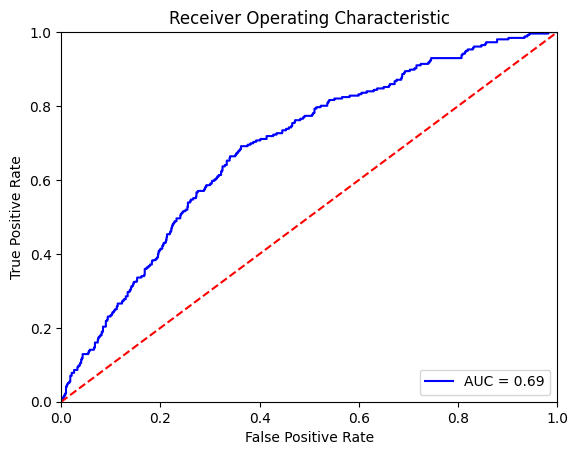

In [13]:
# ROC curve using sigmoid probabilities calculated from genetic scores in the test dataset
fpr, tpr, threshold = roc_curve(list(y_LLFS), torch.sigmoid(outputs2[0]))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

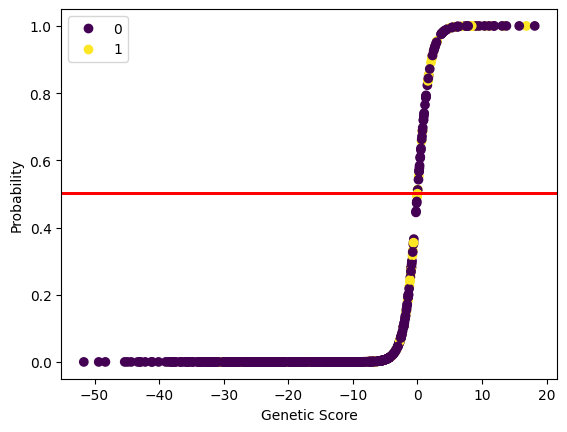

In [14]:
# classification scatterplot
indep, dep = outputs2[0].numpy(), torch.sigmoid(outputs2[0]).numpy()
fig, ax = plt.subplots()
scatter = ax.scatter(indep, dep, c=labels_np)
line = mlines.Line2D(indep, [0.5]*len(dep), color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.legend(*scatter.legend_elements())
plt.xlabel("Genetic Score")
plt.ylabel("Probability")
plt.show()

In [15]:
# saving the latent representation of each module from the model output
LLFS_df2 = LLFS_df.copy()
LLFS_df2['blue_mod'] = outputs2[1]
LLFS_df2['brown_mod'] = outputs2[2]
LLFS_df2['black_mod'] = outputs2[3]
LLFS_df2['pink_mod'] = outputs2[4]

In [16]:
# scaling the covariates
temp = clipper.fit_transform(LLFS_df2[['age', 'educ_years', 'Tcells', 'bmi', 'hscrp', 'il6']])
LLFS_df2[['age', 'educ_years', 'Tcells', 'bmi', 'hscrp', 'il6']] = scaler.fit_transform(temp)

In [17]:
temp = clipper.fit_transform(LLFS_df2[['blue_mod', 'brown_mod', 'black_mod', 'pink_mod']])
LLFS_df2[['blue_mod', 'brown_mod', 'black_mod', 'pink_mod']] = scaler.fit_transform(temp)

In [18]:
# factor conversions
LLFS_df2['sex'] = LLFS_df2['sex'].astype('category')

LLFS_df2['CMV_Serostatus'] = LLFS_df2['CMV_Serostatus'].astype('category')
LLFS_df2['CMV_Serostatus'] = LLFS_df2['CMV_Serostatus'].cat.set_categories(['CMV Negative', 'CMV Positive'], ordered=True)

In [21]:
# Define GLM model using formula notation
glm_model = smf.glm("Deceased ~ blue_mod + brown_mod + black_mod + pink_mod", data=LLFS_df2, family=sm.families.Binomial()).fit()

# Extract odds ratios, confidence intervals, and p-values
odds_ratios = pd.DataFrame({
    'Odds Ratio': np.exp(glm_model.params),  # Convert log-odds to odds ratios
    'Lower CI': np.exp(glm_model.conf_int()[0]),  # Lower bound of 95% CI
    'Upper CI': np.exp(glm_model.conf_int()[1]),  # Upper bound of 95% CI
    'P-value': glm_model.pvalues
}).round(4)

# Display results
print(odds_ratios)

           Odds Ratio  Lower CI  Upper CI  P-value
Intercept      0.2013    0.1710    0.2368   0.0000
blue_mod       0.5461    0.4626    0.6446   0.0000
brown_mod      1.6642    1.4418    1.9208   0.0000
black_mod      0.6328    0.4801    0.8341   0.0012
pink_mod       0.9189    0.7941    1.0633   0.2558
